<a href="https://colab.research.google.com/github/alagarde-bit/Data-Mining-and-Machine-Learning/blob/main/hw03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3 Twitter Analysis
## Alex Lagarde
### 4/11/21

# 1. Setup
#### Imported Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
from sklearn.feature_extraction.text import CountVectorizer 
from operator import itemgetter

#### Reading Dataset

In [ ]:
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1ReTRAhHv_IsWv_gE1sm99lfhu-VkEaYU')
print('Number of Rows:' , len(df))
print(df.dtypes)
df.head(5)

Number of Rows: 5514
Date              object
Screen Name       object
Full Name         object
Tweet Text        object
Tweet ID         float64
App               object
Followers          int64
Follows          float64
Retweets           int64
Favorites          int64
Verfied           object
User Since        object
Location          object
Bio               object
Profile Image     object
dtype: object


,Date,Screen Name,Full Name,Tweet Text,Tweet ID,App,Followers,Follows,Retweets,Favorites,Verfied,User Since,Location,Bio,Profile Image
0,3/15/16,@_Lightscap3s_,Otis,"RT @NatureBridge: ""NatureBridge is Highlight o...",7.100000e+17,RoundTeam,2644,590.0,1,0,No,6/8/09,"Carmel, IN","Artist @ Framed Lightscap3s LLC | Landscape, M...",View
1,3/21/16,@_Lightscap3s_,Otis,RT @NatureBridge: By 2050 we want more fish th...,7.120000e+17,RoundTeam,2641,587.0,2,0,No,6/8/09,"Carmel, IN","Artist @ Framed Lightscap3s LLC | Landscape, M...",View
2,4/6/16,@_Lindsay_Conway,Lindsay,RT @savageducates: Greenest School on #Earth s...,7.180000e+17,Twitter for iPhone,164,318.0,2,0,No,6/7/14,"Bratislava, Slovakia",International education. SEN interests. Adopti...,View
3,3/23/16,@_mcisneros19,Mirella Cisneros,A1: For math children could measure trunks to ...,7.130000e+17,TweetDeck,8,44.0,0,0,No,2/4/16,NaN,NaN,View
4,3/23/16,@_mcisneros19,Mirella Cisneros,A2: Going outside & letting children find the ...,7.130000e+17,TweetDeck,8,44.0,0,0,No,2/4/16,NaN,NaN,View


# 2. Analysis
### a. Top Apps

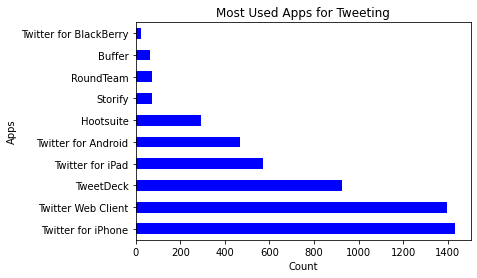

In [ ]:
df['App'].value_counts()[:10].plot(kind = 'barh', color = 'blue', rot = 0)
plt.title('Most Used Apps for Tweeting')
plt.ylabel('Apps')
plt.xlabel('Count')
plt.show()

Twitter is the app used the most frequent for posting tweets. A large percentage of those twitter users appear to be connected to the app through apple products like the iphone and ipad.

### B. Original vs Retweets

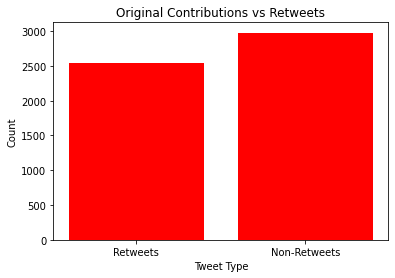

In [ ]:
tweets = df['Tweet Text'].str
retweets = tweets.startswith('RT')
nonRetweets = ~retweets
retweet_counts = len(df['Tweet Text'][retweets])
nonRetweet_counts = len(df['Tweet Text'][nonRetweets])
plt.bar(['Retweets', 'Non-Retweets'], [retweet_counts, nonRetweet_counts], color='red')
plt.title('Original Contributions vs Retweets')
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.show()

The majority of tweets posted are original content; however, it is not by much. Around 2500 out of the 5500 posts are retweets. Therefore, around 45% of the time, tweets are spreading other tweets to other users, which is high considering the amount of users. A fair amount of people would share what other people are talking about over posting something random and personal.

### c. Replies vs Non-Replies

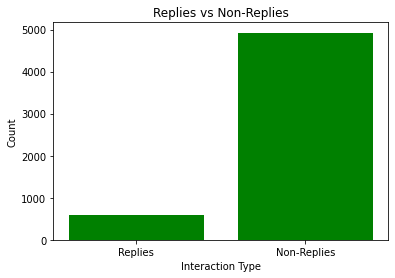

In [ ]:
replies = tweets.startswith('@')
noreplies = ~ replies
reply_counts = len(df['Tweet Text'][replies])
noreply_counts = len(df['Tweet Text'][noreplies])
plt.bar(['Replies', 'Non-Replies'], [reply_counts, noreply_counts], color='green')
plt.title('Replies vs Non-Replies')
plt.xlabel('Interaction Type')
plt.ylabel('Count')
plt.show()

There are far more twitter posts that are not replies than are replies. Meaning there is a small proportion of tweets where there is interaction amongst people.

### d. Distribution of Twitter Poster Followers

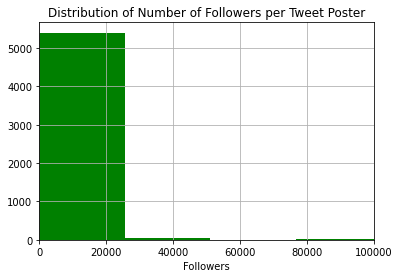

In [ ]:
df.hist('Followers', color = 'green', bins= 30)
plt.title('Distribution of Number of Followers per Tweet Poster')
plt.xlabel('Followers')
plt.xlim(left = 0, right = 100000)
plt.show()

The distribution of the number of followers per tweet poster is right skewed with the majority of counts on the low end. There appears a wide diversification of number of followers within the range of 0 to 20,000 for those who posted. Although, there are posts from users with more than 20,000 followers, the overwhelming, majority have fewer.

#### e. Distribution of Twitter Poster Accounts Followed

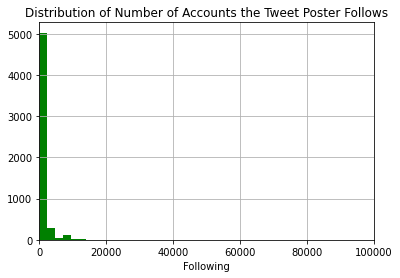

In [ ]:
df.hist('Follows', color = 'green', bins= 30)
plt.title('Distribution of Number of Accounts the Tweet Poster Follows')
plt.xlabel('Following')
plt.xlim(left = 0, right =100000)
plt.show()

The distribution of the number of accounts the tweet poster follows is also very much right skewed. The overwhelming majority follow less than 10,000 accounts. There is less of diversification of the number accounts followed for these posters. This indicates the posters have more followers than accounts followed. There may be a reason they have far more followers than accounts they followed. Perhaps the tweet posters have more credibility. 

### f. Where are People Tweeting?
 i. Number of Tweets from Location

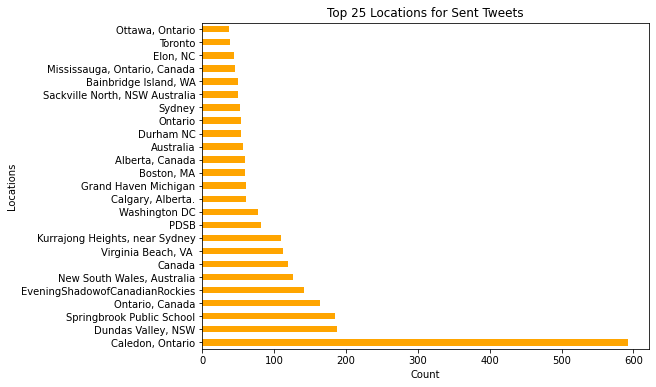

In [ ]:
df2 = df.dropna(subset = ['Location'], axis=0)
df2['Location'].value_counts()[:25].plot(kind='barh', 
                                         color = 'orange', 
                                         rot = 0,
                                         figsize = (8 ,6))
plt.title('Top 25 Locations for Sent Tweets')
plt.xlabel('Count')
plt.ylabel('Locations')
plt.show()

Users tend to be tweeting from Canada, specifically Ontario. In addition, there are sprinkles of Australia and east United States. 

ii. Number of Users from Location

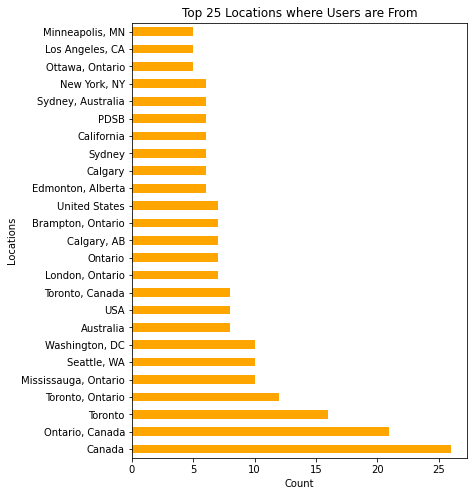

In [ ]:
df3 = df2.drop_duplicates(subset=['Screen Name', 'Location'])
df3['Location'].value_counts()[:25].plot(kind = 'barh',
                                         color = 'orange',
                                         rot = 0,
                                         figsize = (6,8))
plt.title('Top 25 Locations where Users are From')
plt.xlabel('Count')
plt.ylabel('Locations')
plt.show()

Users tend to be from Ontario, Australia, Alberta, and northern USA closer to Canadian border. 

### g. When are People Tweeting?
i. Number of Tweets Each Date

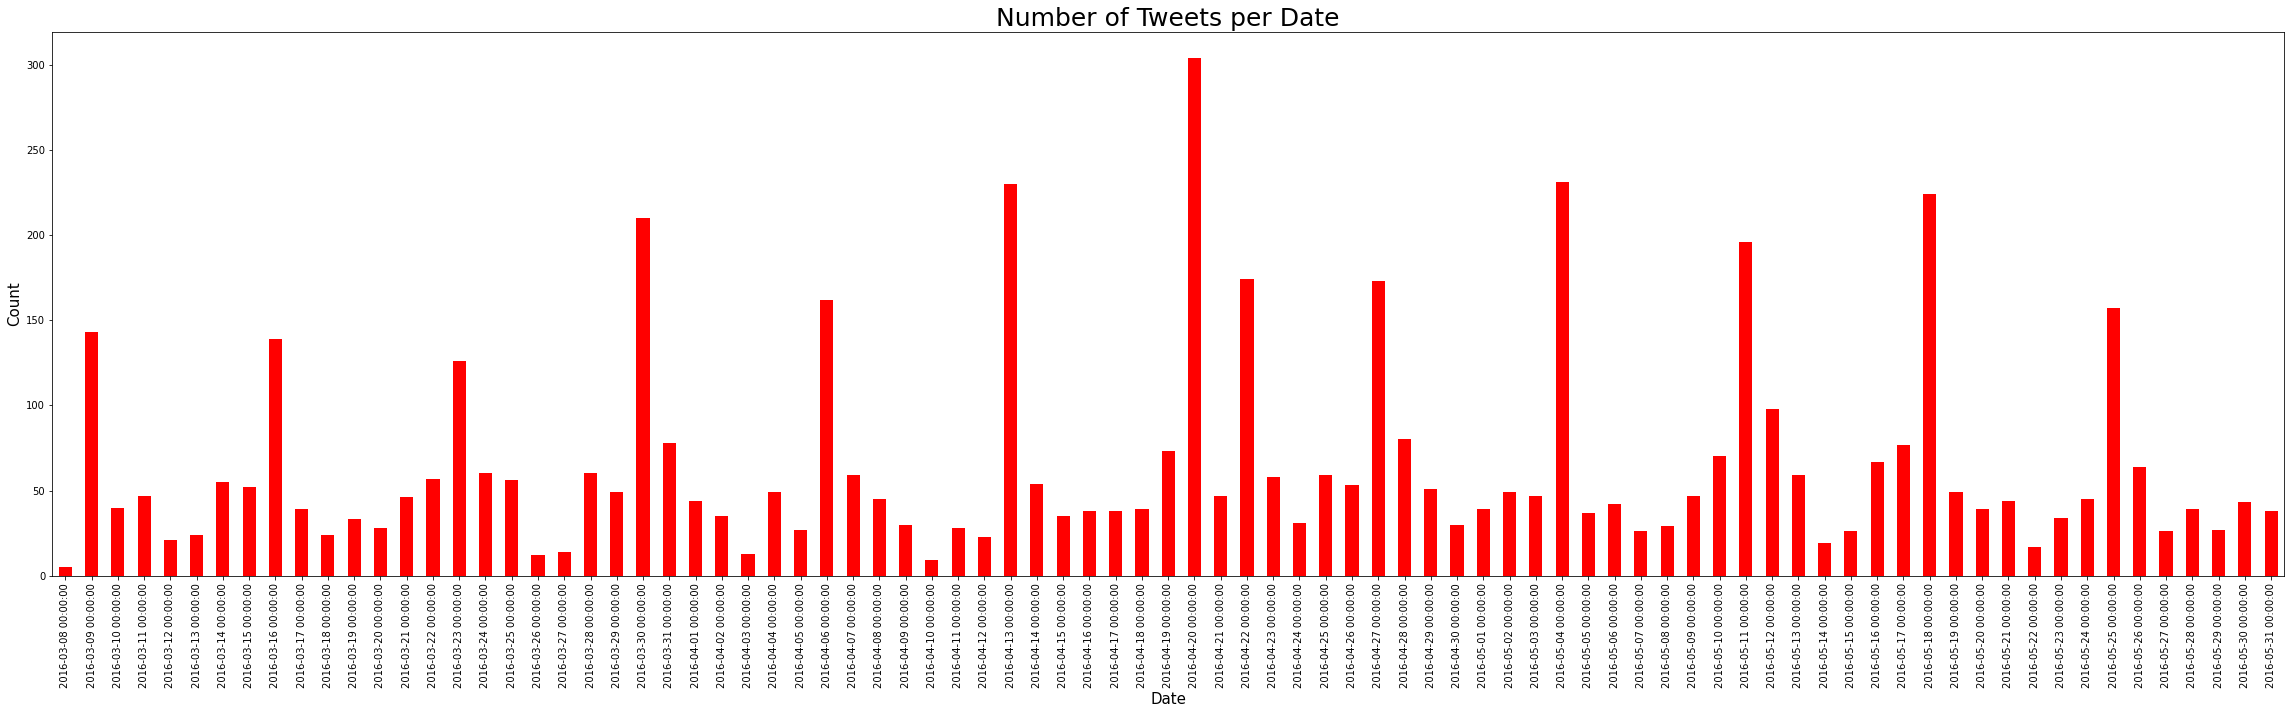

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format = "%m/%d/%y")
df['Date'].value_counts().sort_index().plot(kind = 'bar',
                                            color = 'red',
                                          figsize = (40,10))
plt.title('Number of Tweets per Date', fontdict={'size': 25})
plt.xlabel('Date', fontdict={'size': 15})
plt.ylabel('Count', fontdict={'size': 15})
plt.show()

Users are tweeting during the spring of 2016. During this period of time, there were political elections both in Canada and the United States. The public seems to have consistent rhythm of when they tweet most and least. 

ii. Number of Tweets Each Day of the Week

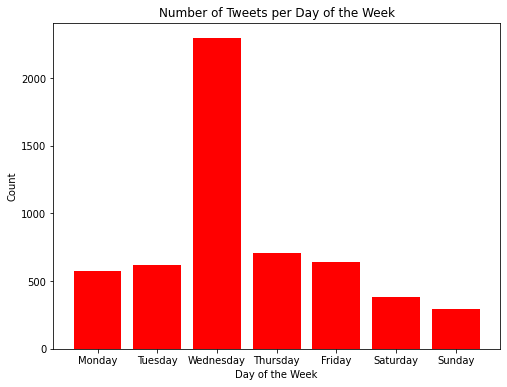

In [ ]:
df['Weekday'] = df['Date'].dt.day_name()
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
new_df = df.groupby('Weekday').count().reindex(weekdays)
plt.figure(figsize=(8,6))
plt.bar(new_df.index, new_df['Date'], color = 'red')
plt.title('Number of Tweets per Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.show()



Wednesday is the most popular day of the week for tweets during this spring time frame in 2016, while the weekends have the least amount of action. This could largely be due to the republican primaries that were running every wednesday involving Donald Trump. 

### h. What are People Tweeting?

In [ ]:
tweets2 = df['Tweet Text']
def find_hashtags(tweet):
    return re.findall(r"#(\w+)", tweet)  
topics = tweets2.apply(find_hashtags)
topics = topics.astype(str).str.replace('\[|\]|\'', '')

i. Words

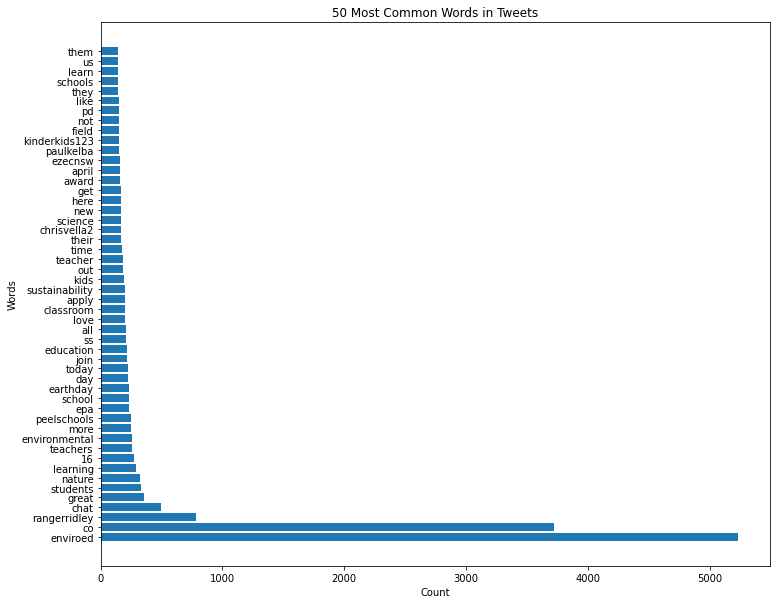

In [ ]:
stop_list = ['a', '10','rt', 'an', 'the', 'it', 'is', 'i', 'and', 'or','as', 'do', 'what', 'can', 'by', 'am', 'are', 'have', 'so', 'of', 'in', 'on', 'to', 'for', 'in' 'but', 'be', 'that', 'with', 'that', 'will','RT', 'our', 'https', 'this', 'you', 'we', 'at', 'your', 'how', 'about', 'may', 'my', 'from']
count_vect = CountVectorizer(lowercase=True, stop_words=stop_list)
data_counts = count_vect.fit_transform(tweets2)
x = count_vect.get_feature_names()
y = np.array(data_counts.todense()).sum(axis=0)
common_words = pd.DataFrame()
common_words['Words'] = x
common_words['Count'] = y
common_words = common_words.sort_values(by = 'Count', ascending=False)
plt.figure(figsize=(12,10))
plt.barh(common_words['Words'][:50], common_words['Count'][:50])
plt.title('50 Most Common Words in Tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()


ii. Topics

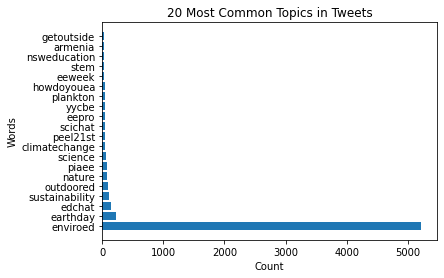

In [ ]:
count_vect2 = CountVectorizer(lowercase=True, stop_words=None)
data_counts2 = count_vect2.fit_transform(topics)
x2 = count_vect2.get_feature_names()
y2 = np.array(data_counts2.todense()).sum(axis=0)
common_topics = pd.DataFrame()
common_topics['Words'] = x2
common_topics['Count'] = y2
common_topics = common_topics.sort_values(by = 'Count', ascending=False)
plt.barh(common_topics['Words'][:20], common_topics['Count'][:20])
plt.title('20 Most Common Topics in Tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()


Users were tweeting mostly about the environment, nature, science,  and the outdoors. There were also quite a few tweets regarding education, youth, and learning. During this time period, there must have been some environmental crisis going on, where people were bringing awareness and promoting education. Enviroed is the signature hashtag of this group, which indicates they are trying to encourage environmental education. 

### i. Who is Tweeting?
i. Creating Directed Weighted Social Network Graph

In [ ]:
G = nx.DiGraph()
for idx, row in df.iterrows():
  from_node = row['Screen Name']
  G.add_node(from_node)
  for i in df['Screen Name'].unique():
    if i in row['Tweet Text']:
      to_node = i
      if G.has_edge(from_node, to_node):
         weight = G.get_edge_data(from_node, to_node)['attr']
         new_weight = weight['weight'] + 1
         G.add_edge(from_node, to_node, attr = {'weight': new_weight})
      else:
         G.add_edge(from_node, to_node, attr ={'weight': 1} )

ii. Showing Graph Info

In [ ]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 1613
Number of edges: 2966
Average in degree:   1.8388
Average out degree:   1.8388


iii. Calculating In-Degree, Out-Degree, Betweenness Centrality, Eigenvector Centrality, and Closeness Centrality for Each Node

In [ ]:
in_degree_dict = dict(G.in_degree(G.nodes()))
nx.set_node_attributes(G, in_degree_dict, 'in_degree')

out_degree_dict = dict(G.out_degree(G.nodes()))
nx.set_node_attributes(G, out_degree_dict, 'out_degree')

betweenness_dict = nx.betweenness_centrality(G)
nx.set_node_attributes(G, betweenness_dict, 'betweenness')

closeness_dict = nx.closeness_centrality(G)
nx.set_node_attributes(G, closeness_dict, 'closeness')

eigenvector_dict = nx.eigenvector_centrality(G)
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')

iv. Printing Top 20 Users for In-Degree, Out-Degree, Betweenness Centrality, and Eigenvector Centrality

In [ ]:
sorted_in_degree = sorted(in_degree_dict.items(), key = itemgetter(1), reverse=True)
print('In Degree Centrality Top 20 Rankings')
for i in sorted_in_degree[:20]:
  print(i)

In Degree Centrality Top 20 Rankings
('@RangerRidley', 245)
('@EPA', 169)
('@PeelSchools', 91)
('@EnviroEducators', 70)
('@PaulKelba', 60)
('@KinderKids123', 54)
('@CWF_FCF', 48)
('@PDSB_eco', 45)
('@IslandWood', 45)
('@ChrisVella2', 41)
('@NAAEEStaff', 40)
('@Sierra_BC', 39)
('@stevenbody', 39)
('@MindShiftKQED', 38)
('@KinderFynes', 38)
('@EZECNSW', 37)
('@CreativeSTAR', 36)
('@ON_EcoSchools', 35)
('@PlanktonPundit', 35)
('@AlbertaEE', 34)


In [ ]:
sorted_out_degree = sorted(out_degree_dict.items(), key = itemgetter(1), reverse=True)
print('Out Degree Centrality Top 20 Rankings')
for i in sorted_out_degree[:20]:
  print(i)

Out Degree Centrality Top 20 Rankings
('@RangerRidley', 104)
('@DavidSpencerEdu', 47)
('@PaulKelba', 37)
('@Learn_OnTheFly', 37)
('@stevenbody', 29)
('@EZECNSW', 28)
('@ChrisVella2', 27)
('@KinderKids123', 18)
('@CWF_FCF', 16)
('@doctormorrison', 14)
('@OCSBeco', 14)
('@WestSydUFood_Ag', 14)
('@PDSB_eco', 13)
('@vivianharris45', 13)
('@MikeBartlettEdu', 13)
('@KinderFynes', 12)
('@NAAEEStaff', 12)
('@PeelSchools', 11)
('@BearTrust', 11)
('@BrewongleEEC', 11)


In [ ]:
sorted_betweenness = sorted(betweenness_dict.items(), key = itemgetter(1), reverse=True)
print('Betweenness Centrality Top 20 Rankings')
for i in sorted_betweenness[:20]:
  print(i)

Betweenness Centrality Top 20 Rankings
('@RangerRidley', 0.0519588500590444)
('@PaulKelba', 0.016001991699417042)
('@NAAEEStaff', 0.01342167779985907)
('@Learn_OnTheFly', 0.013411155292148483)
('@EnviroEducators', 0.0070857235232592896)
('@IslandWood', 0.0062317064911376185)
('@GEOEC', 0.0059024828145214335)
('@CWF_FCF', 0.005303628636270944)
('@DavidSpencerEdu', 0.0045387901141257046)
('@doctormorrison', 0.004348786645868092)
('@PDSB_eco', 0.0038959937346918524)
('@KinderKids123', 0.0038636416824780087)
('@EZECNSW', 0.0033676972855484033)
('@Sierra_BC', 0.003346830884640159)
('@perfinker', 0.002830124329233673)
('@PeelSchools', 0.0028263793581090424)
('@stevenbody', 0.002624803898775374)
('@CreativeSTAR', 0.002618417056849143)
('@ChrisVella2', 0.002529885383503862)
('@AAPremlall', 0.0023804571786585306)


In [ ]:
sorted_eigenvector = sorted(eigenvector_dict.items(), key = itemgetter(1), reverse=True)
print('Eigenvector Centrality Top 20 Rankings')
for i in sorted_eigenvector[:20]:
  print(i)

Eigenvector Centrality Top 20 Rankings
('@RangerRidley', 0.4361236243939317)
('@ChrisVella2', 0.24746260317785634)
('@EZECNSW', 0.23541902464795714)
('@stevenbody', 0.22491615382764313)
('@PaulKelba', 0.19841387914159442)
('@LShenstone', 0.1766530863887344)
('@vivianharris45', 0.16931699669725037)
('@PeelSchools', 0.16660698645683733)
('@KinderKids123', 0.16029813458550565)
('@KateHelene', 0.1497656089615079)
('@DebHoggoz', 0.14880473229105737)
('@doctormorrison', 0.14716914372196677)
('@KinderFynes', 0.1421909551427632)
('@steve_papp', 0.13609153619599457)
('@BrewongleEEC', 0.12999309904402057)
('@FieldofMarsEEC', 0.1284553150631183)
('@CWF_FCF', 0.12287961433455542)
('@MikeBartlettEdu', 0.11669270807331625)
('@LongneckLagoon', 0.11626310823574883)
('@CherineSpirou', 0.1096963366158304)


v. Top 20 Lists Observations
 
RangerRidley is the most active user and most popular user in this network. He has the highest measure in all four metrics meaning he has the most people tweeting at him, he tweets at the most people, most of the shortest paths of connections go through him, and the highly connected people connect to him.Accounts in the in-degree rankings tend to be ranked lower in the out-degree rankings. The same types of accounts are circulating around these rankings. This network is run mostly by environmental organizations, teachers, and education programs.

vi. Making Visual Subgraphs for Three Users

In [ ]:
rangerRidley = ['@RangerRidley']
for e in G.edges():
  if e[0] == '@RangerRidley':
    rangerRidley.append(e[1])
  elif e[1] == '@RangerRidley':
    rangerRidley.append(e[0])
H = G.subgraph(rangerRidley)
R = G.subgraph('@RangerRidley')

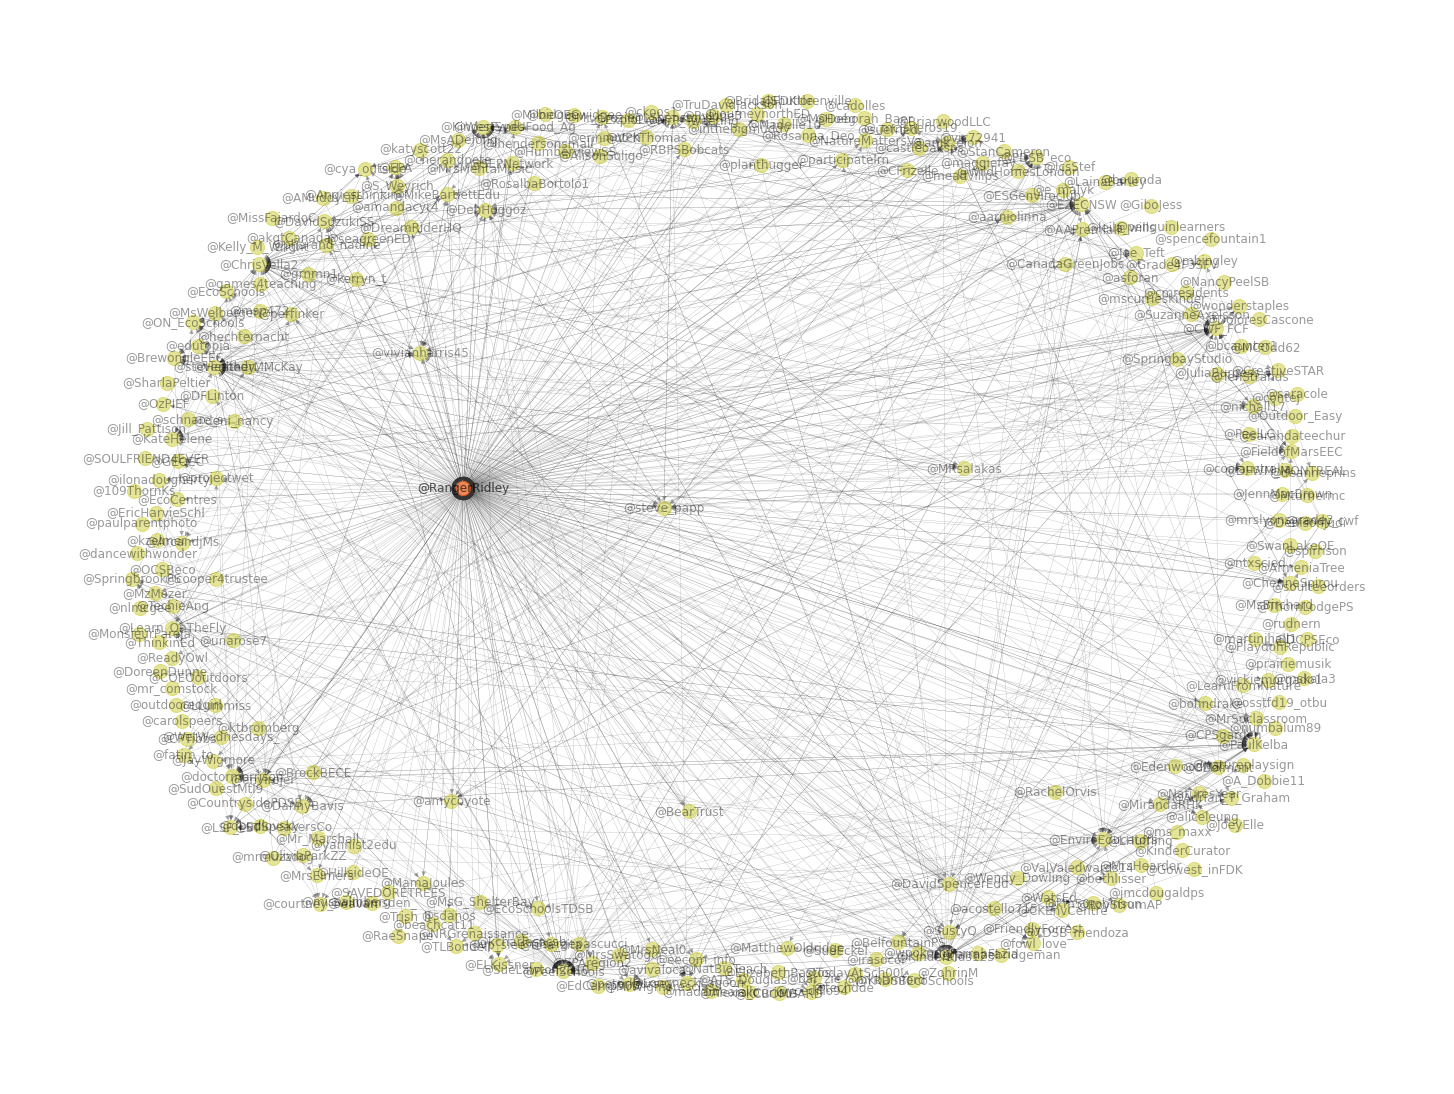

In [ ]:
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(H, k=2.2)
nx.draw(H, pos=pos, node_size=200, 
        node_color = 'y',
        edge_color="#333333",
        alpha=0.4, 
        with_labels=True,
        width = 0.3)
nx.draw(R, pos=pos, node_size=200, 
        node_color = 'r',
        edge_color="#333333",
        alpha=0.4, 
        with_labels=True,
        width = 0.3)

In [ ]:
EPA = ['@EPA']
for e in G.edges():
  if e[0] == '@EPA':
    EPA.append(e[1])
  elif e[1] == '@EPA':
    EPA.append(e[0])
I = G.subgraph(EPA)
S = G.subgraph('@EPA')

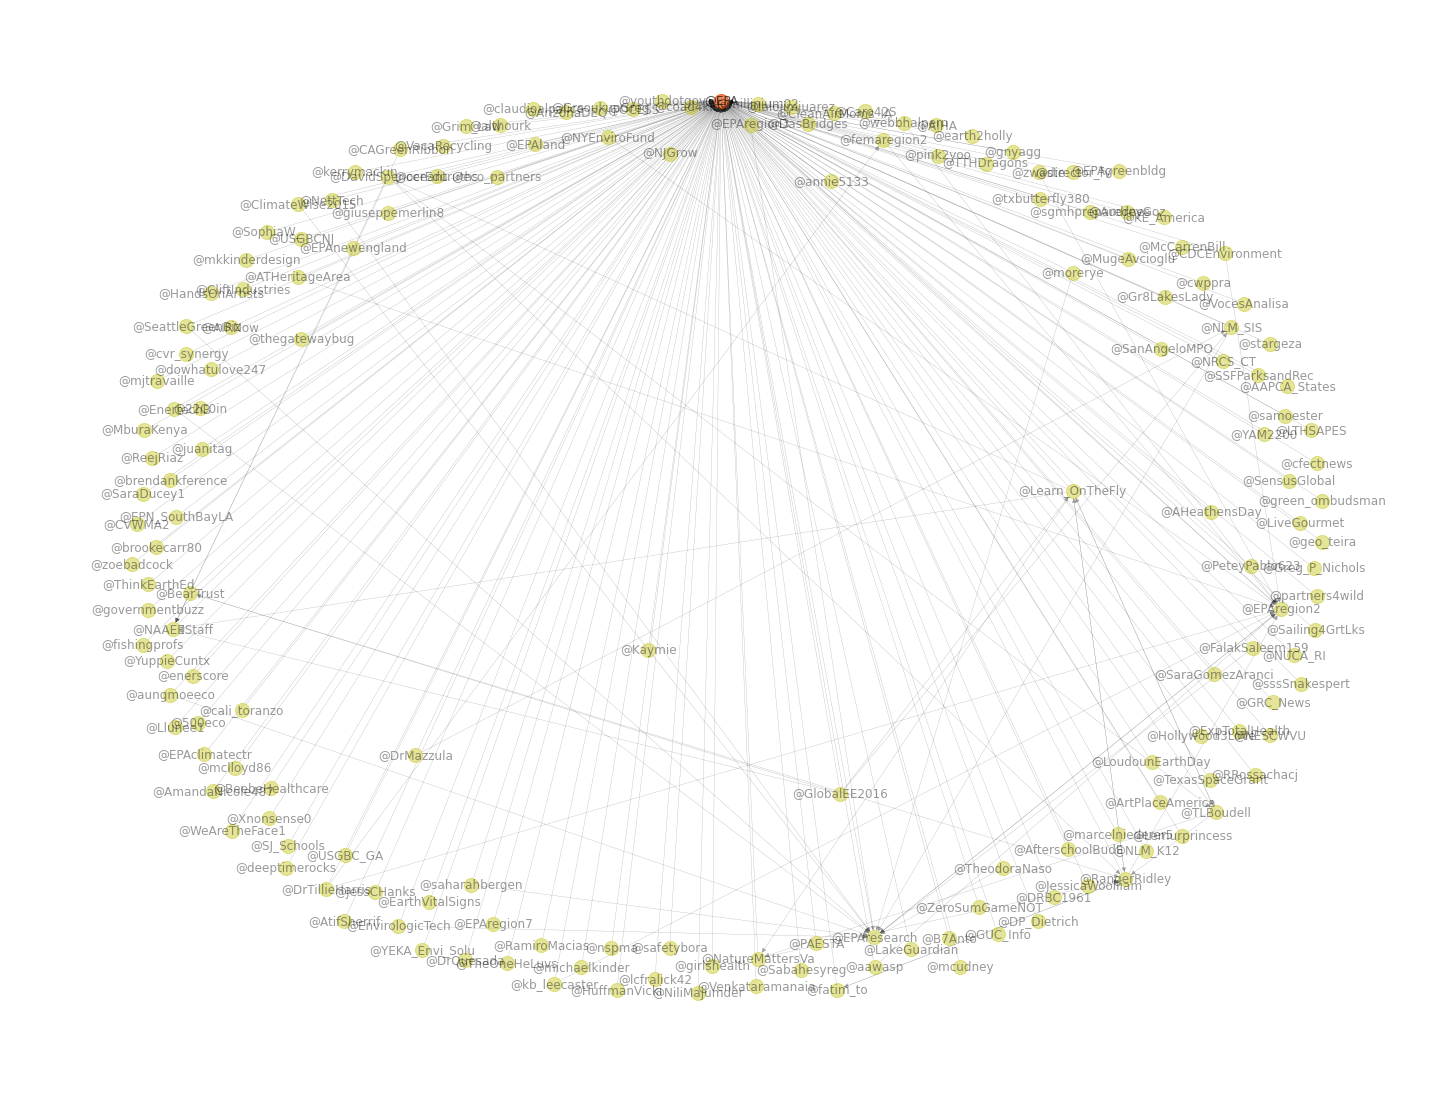

In [ ]:
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(I, k=1.8)
nx.draw(I, pos=pos, node_size=200, 
        node_color = 'y',
        edge_color="#333333",
        alpha=0.4, 
        with_labels=True,
        width = 0.3)
nx.draw(S, pos=pos, node_size=200, 
        node_color = 'r',
        edge_color="#333333",
        alpha=0.4, 
        with_labels=True,
        width = 0.3)

In [ ]:
paulKelba = ['@PaulKelba']
for e in G.edges():
  if e[0] == '@PaulKelba':
    paulKelba.append(e[1])
  elif e[1] == '@PaulKelba':
    paulKelba.append(e[0])
J = G.subgraph(paulKelba)
T = G.subgraph('@PaulKelba')

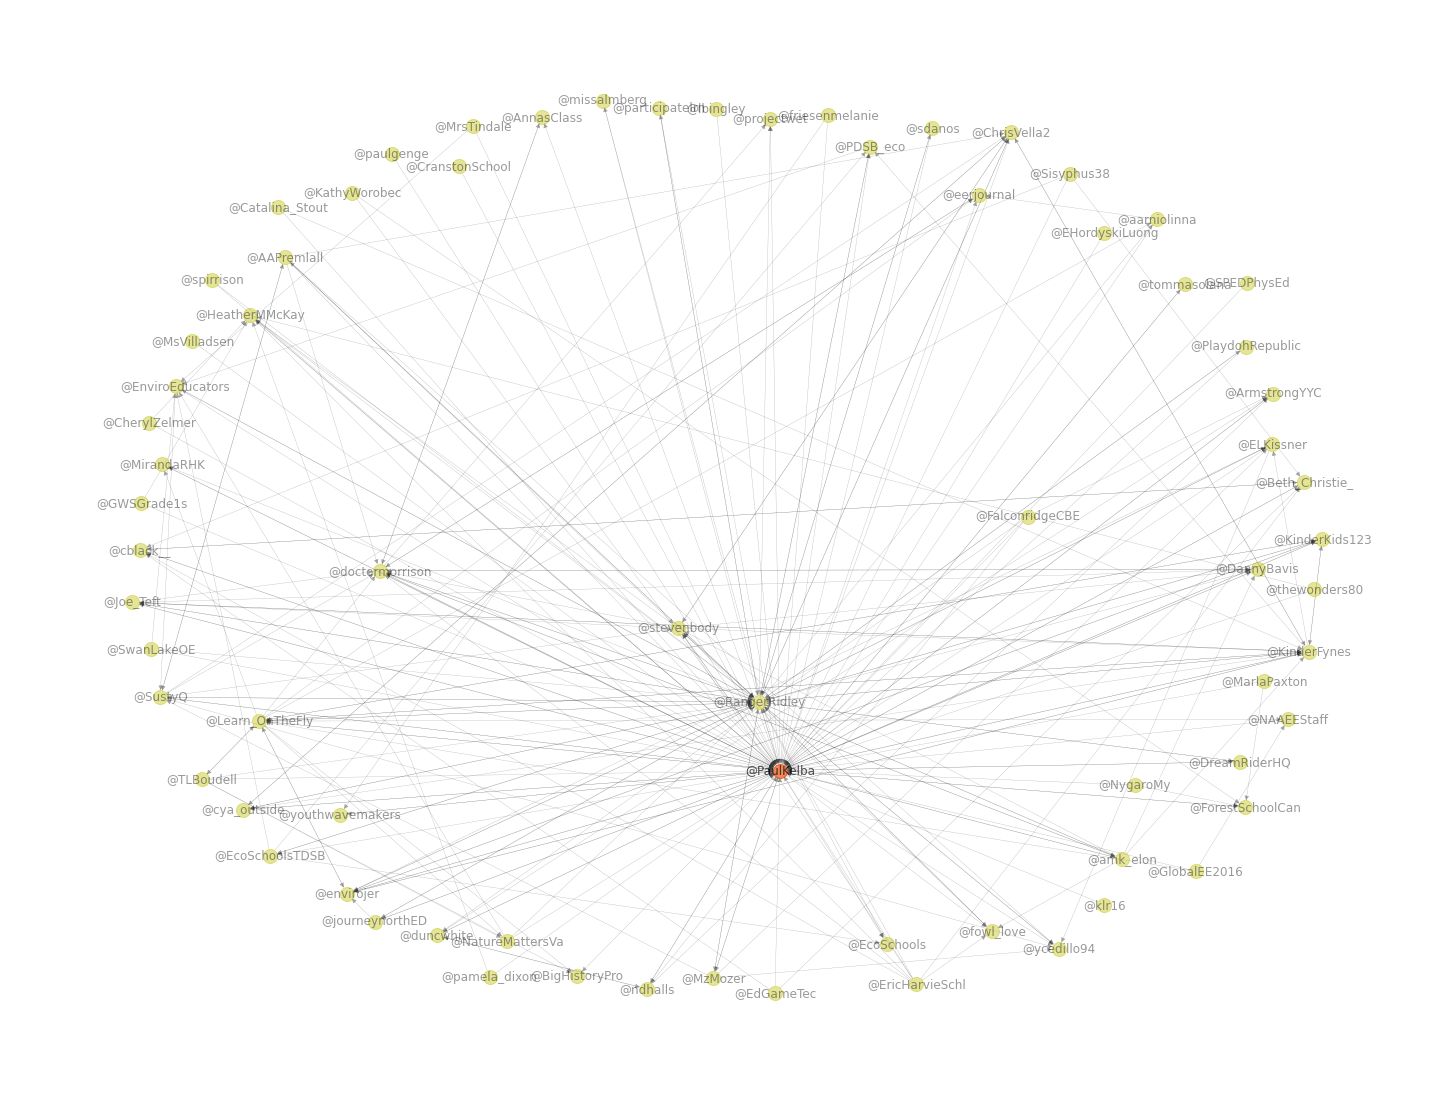

In [ ]:
plt.figure(figsize=(20, 15))
pos = nx.spring_layout(J, k=2.2)
nx.draw(J, pos=pos, node_size=200, 
        node_color = 'y',
        edge_color="#333333",
        alpha=0.4, 
        with_labels=True,
        width = 0.3)
nx.draw(T, pos=pos, node_size=200, 
        node_color = 'r',
        edge_color="#333333",
        alpha=0.4, 
        with_labels=True,
        width = 0.3)

vii. Subgraph and Specific Nodes Observations

RangerRidley clearly seems to be the leader of this social network. Visually, all the edges seem to be going to him, and he is first in every metric category. EPA or the Environmental Protection Agency, has a lot of in-degrees because environmental topics tend to involve them, but the organization does not seem connected to the network. They have the second highest in-degree, but it is not in the top 20 of any other metric. This suggests they are not involved in the network. Paul Kelba is the second most influential person in the network. Ranked top 5 in all metrics, Paul Kelba gets tweet at, tweets at other users, connects different types of people in the network, and is connected with other highly connected users. 

### j. What do Users Put in Bios?

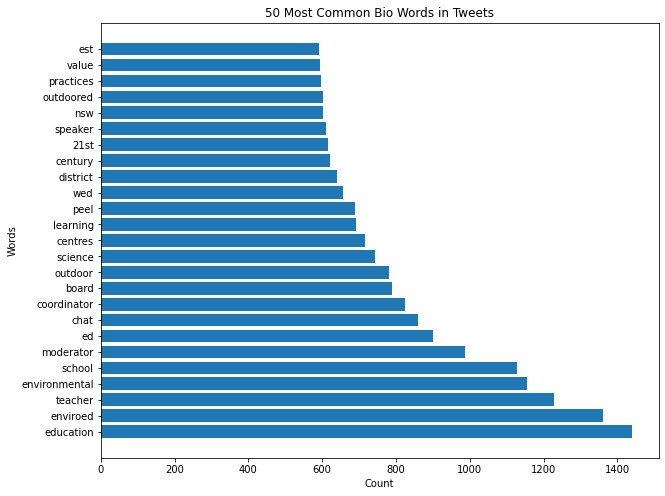

In [ ]:
df_bio = df.dropna(axis = 0, subset=['Bio'])
bios = df_bio['Bio']
count_vect3 = CountVectorizer(lowercase=True, stop_words= stop_list)
data_counts3 = count_vect3.fit_transform(bios)
x3 = count_vect3.get_feature_names()
y3 = np.array(data_counts3.todense()).sum(axis=0)
bio_words = pd.DataFrame()
bio_words['Words'] = x3
bio_words['Count'] = y3
bio_words = bio_words.sort_values(by = 'Count', ascending=False)
plt.figure(figsize=(10,8))
plt.barh(bio_words['Words'][:25], bio_words['Count'][:25])
plt.title('50 Most Common Bio Words in Tweets')
plt.xlabel('Count')
plt.ylabel('Words')
plt.show()

Since a bio is used to write a introduction of who you are, it seems that in this social network, users identify themselves through their profession and what they do. Also, there is a clear indication that the users are in the same environmental education group with similar outdoor education jobs. These users seem to knowledgeable about nature science, and they dedicate their lives to speak to people to teach them about the environment. 